# Welcome to Flarenet!

This notebook introduces Flarenet, a machine learning model developed to identify stellar flares in TESS 20-s cadence data. To learn more about the code, check out Berger et al, (2025). 

The flarenet model was trained using 20-second cadence TESS data. First, we identified by eye ~1000 lightcurves that were relatively quiet (no flares). We then injected sythetic flares into the data using the [Llamaradas Estelares](https://github.com/lupitatovar/Llamaradas-Estelares) model. The distribution of the FWHM/amplitudes of the injected flares were drawn from the population identified by [Guenther et al, 2020](https://arxiv.org/abs/1901.00443). 

Unlike the 2-minute and Full Frame Image TESS data products, the 20-s cadence data product does not reject cosmic rays onboard the spacecraft. Instead, this is done during data processing on the ground. The removed cosmic rays are available in an extension to the fits file. We "add" these cosmic rays back into training data to help the model distinguish between cosmic rays and flares.

Using this training dataset, we create the flarenet model. We construct a neural network that takes in 500 timestep cutouts from the full lightcurve. The model returns a value between 0 (certainly not a flare) and 1 (definitely a flare). During training, an equal number of random samples are drawn from the training dataset that either contain injected flares or that do not. In addition, we randomly inject variability (sinusoidal stellar activity, RR-Lyrae-like variability, exoplanet transits, and asteroid crossing artifacts) to some of the data. This is done to reduce the number of false positive flare identifications. 

While users are able to generate and train their own model using the codes avialable in flarenet, the default behavior (and what is presented here) is to use the pre-trained model to make predictions. Please take a look at the examples below. If you have any questions, please let us know via a github issue. 

In [1]:
%matplotlib inline

In [2]:
import os
import sys
sys.path.append("../src")
import flarenet
import lksearch

/Users/nthom/opt/anaconda3/envs/flarenet/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


First, we will demonstrate how to create the input data using the TessStar class. In practice, this is handled automatically by flarenet. However, we will walk through the steps here manually for reference. In this case, let's say we are interested in looking at the star AU Mic, a young M dwarf star that [is known](https://arxiv.org/abs/2109.03924) to flare frequently.  

In [3]:
# For demonstration only, we will search for the star manually to get the TICID and available sectors
sr=lksearch.TESSSearch("AU Mic", exptime=20).timeseries
sr

,target_name,pipeline,mission,sector,exptime,distance,year,description
0,441420236,SPOC,TESS,27,20.0,0.0,2020,Light curves


OK, AU Mic has the TESS Input Catalog ID 441420236, and only has one sector of available 20-second data. We can use this information to create a TessStar.

As we will be making flare predictions on this dataset, for this example, we will add the cosmic rays back in the data, although this is optional. However, when we use flarenet to predict flares, it will be interesting to see how the model performs for the cosmic rays. 

We also have the flag cloud=False. This indicates whether you want to access the TESS data from the MAST servers or on MAST's cloud platform on AWS. If you do not use cloud data, the fits file will be downloaded locally to your lightkurve cache. 

In [4]:
au_mic = flarenet.TessStar(441420236, sector=27, add_cosmic_rays=True, cloud=False)

In [5]:
# The au_mic object stores information as properites. For example, you can access the lightcurve information:
au_mic.lc

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,,,pix,pix,,
Time,float32,float32,float64,float64,int32,int32
2036.2834520761414,0.9947529435157776,0.00045151080121286213,475.60808806852805,1247.0257724334838,3494118,0
2036.2836835649678,0.9949482083320618,0.0004515956388786435,475.61677536410986,1247.040747118844,3494119,0
2036.2839150533287,0.9944576621055603,0.0004514913889579475,475.59518708981784,1247.0573680554817,3494120,0
2036.2841465421548,0.9945974349975586,0.00045149604557082057,475.63104442401504,1247.0222326138312,3494121,0
2036.2843780309804,0.9956104159355164,0.0004517630150076002,475.6224390729358,1246.9884828791778,3494122,0
2036.2846095198063,0.9947702884674072,0.0004515415639616549,475.61161450807356,1247.0273677599835,3494123,0
2036.2848410081665,0.9937642812728882,0.0004513791936915368,475.6262755242974,1247.0147317921842,3494124,0
2036.2850724969921,0.9952340126037598,0.00045163699542172253,475.60012350241135,1247.0277649752406,3494125,0


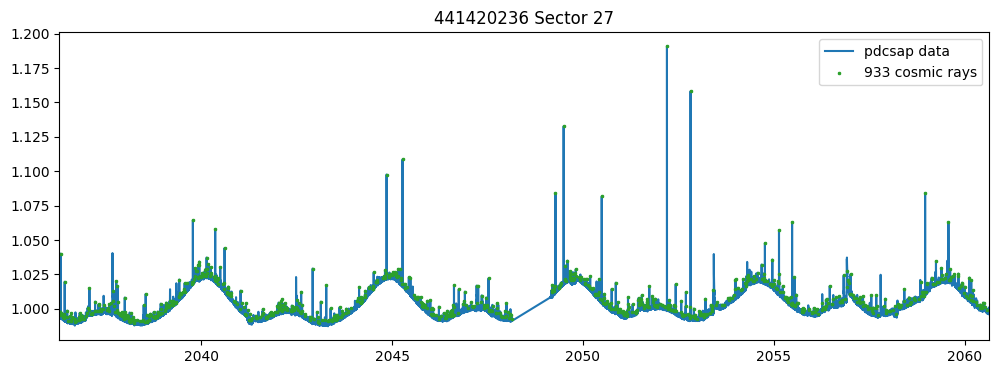

In [6]:
# There are also some usful functions for TessStar objects, such as plotting
au_mic.plot_lc(save_plot=False) # Just print the plot to screen

You can see AU Mic is very active, showing both large scale variability and short scale flares. 

If you wanted to add more flares to the data, you could do this using au_mic.inject_training_flares(). However, we want to make predictions on the actual data, so we will not do that in this example. Let's save this data out as a csv file, which can be used as input to the flarenet model. We specify train=False, as we are not using this as a training sample.

In [7]:
aumic_path = au_mic.save_data(train=False) # returns the path to where the file was saved

Now it's time to make our prediction! There is a second data class called Flarenet that enables several functions for both training and prediction. We will start by instantiating the object.



In [8]:
fn = flarenet.Flarenet()

loading model weights from file /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/model_weights.weights.h5


By default, it will load in the model and weights that we can pre-trained. However, if you have retrained the model, you can use those weights by pointing to their path with the model_weights keyword. 
                

Preparing file for TIC 441420236


No predictions available for TIC 441420236 Sector 27. Starting prediction for file: /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/prediction_data/441420236_27_data.csv
Starting to prep data for file: /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/prediction_data/441420236_27_data.csv
CSV file loaded. Shape before cleaning: (100736, 6)
Gap filling complete for TIC /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/prediction_data/441420236_27_data.csv. Added 4520 new time points.
All segments processed. Final shape: (105256, 7)
Data after padding. Final shape: (105756, 7)
Preparing final data
Prepared data shape: (105756,)


100%|████████████████████████████████| 105256/105256 [00:07<00:00, 14251.17it/s]


3290/3290 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step
Predictions shape: (105756,)
Successfully processed file: /Users/nthom/TESS_GI/gitNschanch/flarenet/src/flarenet/prediction_data/441420236_27_data.csv


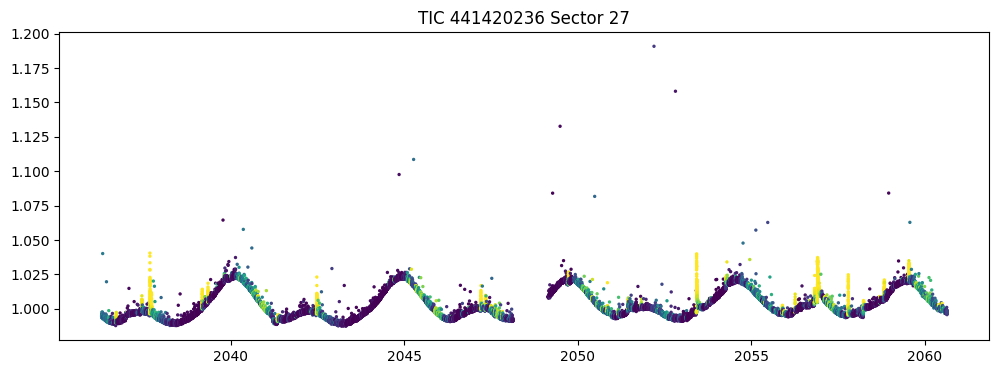

In [13]:
aumic_preds = fn.predict(441420236, sector=27, save_plot=False) #save_plot=False prints plot to screen rather than saving a file

voila! You have the flare predictions. You can see that the final dataframe contains the time, flux, and errors, as well as the quality flags, and cosmic ray flags (if cosmic rays were injected). There is also a column for flare flags, which will populate with '1's when flags are injected. This does NOT reflect detected flares. In this cases, we didn't inject flares, so the values will all be 0.

In [14]:
aumic_preds

,index,time,flux,flux_err,quality,cr_flags,flare_flags,model_prediction
0,250,2036.283452,0.994753,0.000452,0,0,0.0,0.327633
1,251,2036.283684,0.994948,0.000452,0,0,0.0,0.330312
2,252,2036.283915,0.994458,0.000451,0,0,0.0,0.332132
3,253,2036.284147,0.994597,0.000451,0,0,0.0,0.332864
4,254,2036.284378,0.995610,0.000452,0,0,0.0,0.332800
...,...,...,...,...,...,...,...,...
100731,105501,2060.647478,0.998688,0.000456,0,0,0.0,0.182785
100732,105502,2060.647709,0.997160,0.000456,0,0,0.0,0.191795
100733,105503,2060.647941,0.998802,0.000456,0,0,0.0,0.196210
100734,105504,2060.648172,0.997053,0.000456,1024,0,0.0,0.209050
